# ETL thesis
This notebook gets thesis data from Pure and creates several visualisations.

### TODO
- Separate request URL in parameters
- Fetch all results in batches of 500 or 1000
- Export values from data frame to linked data RDF

In [1]:
import requests
from requests.auth import HTTPBasicAuth
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load API token from secrets file (.env)
%load_ext dotenv
%dotenv
import os

api_token = os.getenv("API_TOKEN")

### Config

In [58]:
# Default page size is 10
url = 'https://crisapi.library.maastrichtuniversity.nl/api/ResearchOutput?types=/dk/atira/pure/researchoutput/researchoutputtypes/thesis/doc&year_begin=2010&year_end=2020&extra=personAssociations,publicationStatuses'

# Page size modified
#url = 'https://crisapi.library.maastrichtuniversity.nl/api/ResearchOutput?types=/dk/atira/pure/researchoutput/researchoutputtypes/thesis/doc&size=500&year_begin=2010&year_end=2020&extra=personAssociations,publicationStatuses'

headers = {'Accept': 'application/xml', 'UBKey': api_token}

### Start of script

Perform API call

In [59]:
out = requests.get(url, headers=headers)

Convert response to XML tree

In [60]:
string_xml = ET.fromstring(out.content)
tree = ET.ElementTree(string_xml)
#ET.dump(tree)
root = tree.getroot()

# TODO: Use better method to select items-tag
items = root[2]

Load publication data in data frame

In [61]:
df_cols = ["uuid", "title", "author", "author_uuid", "year", "language", "org_unit_uuid", "org_unit_extid", "org_unit_name", "doi"]
rows = []

for node in items.findall(".//thesis"):
    pub_uuid = node.attrib.get("uuid")
    pub_title = node.find("title").text
    
    if node.find("./personAssociations/personAssociation/person/name/text") is not None:
        pub_author = node.find("./personAssociations/personAssociation/person/name/text").text
        pub_author_uuid = node.find("./personAssociations/personAssociation/person").attrib.get("uuid")
    elif node.find("./personAssociations/personAssociation/externalPerson/name/text") is not None:
        pub_author = node.find("./personAssociations/personAssociation/externalPerson/name/text").text
        pub_author_uuid = node.find("./personAssociations/personAssociation/externalPerson").attrib.get("uuid")
    else:
        pub_author = "NA"
        pub_author_uuid = "NA"

    pub_year = node.find("./publicationStatuses/publicationStatus/publicationDate/year").text
    pub_lang = node.find("./language/term/text").text
    
    if node.find("./personAssociations/personAssociation/organisationalUnits/organisationalUnit/name/text") is not None:
        pub_org_unit_uuid = node.find("./personAssociations/personAssociation/organisationalUnits/organisationalUnit").attrib.get("uuid")
        pub_org_unit_extid = node.find("./personAssociations/personAssociation/organisationalUnits/organisationalUnit").attrib.get("externalId")
        # Ugly data quality replacement
        if pub_org_unit_extid is None:
            pub_org_unit_extid = "NA"
        pub_org_unit_name = node.find("./personAssociations/personAssociation/organisationalUnits/organisationalUnit/name/text").text
    else:
        pub_org_unit_uuid = "NA"
        pub_org_unit_name = "NA"

    
    if node.find("./electronicVersions/electronicVersion/doi") is not None:
        pub_doi = node.find("./electronicVersions/electronicVersion/doi").text
    else: 
        pub_doi = "NA"
    
    rows.append({"uuid": pub_uuid,
                 "title" : pub_title,
                 "author" : pub_author,
                 "author_uuid" : pub_author_uuid,
                 "year" : pub_year,
                 "language" : pub_lang,
                 "org_unit_uuid" : pub_org_unit_uuid,
                 "org_unit_extid" : pub_org_unit_extid,
                 "org_unit_name" : pub_org_unit_name,
                 "doi" : pub_doi
                })
    
pub_df = pd.DataFrame(rows, columns = df_cols)

In [49]:
#print(pub_df)

Publication date Visualisation


In [39]:
#pub_df['year'].hist()

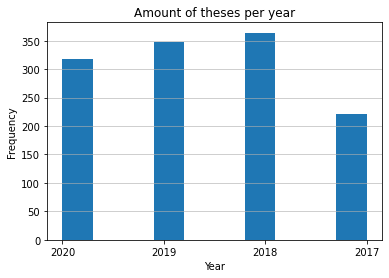

In [40]:
plt.hist(x=pub_df['year'])
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Amount of theses per year')
plt.show()

Publication language visualisation

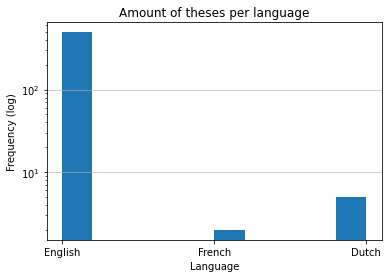

In [125]:
plt.hist(x=pub_df['language'], log=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Language')
plt.ylabel('Frequency (log)')
plt.title('Amount of theses per language')
plt.show()

Organizational Unit visualisation

In [122]:
top10_departments = pub_df.groupby('org_unit_extid').size().sort_values(ascending=False)[0:10]

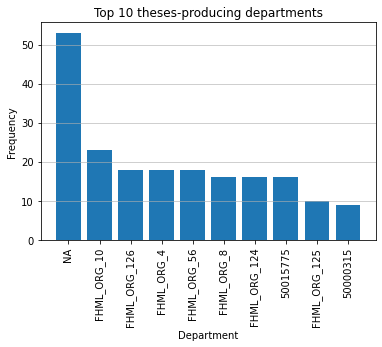

In [123]:
plt.bar(x=top10_departments.keys(), height=top10_departments)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Department')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')
plt.title('Top 10 theses-producing departments')
plt.show()